# Label side

In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-06-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

candles.shape

(2848320, 6)

In [2]:
np.save("data/btc_1m.npy", candles)

In [39]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

(2848320, 6)

In [40]:
from scipy import stats
from custom_indicators.toolbox.bar.fusion.v2 import FusionBarContainerV2

bar_container = FusionBarContainerV2(max_bars=20000)
bar_container.update_with_candles(candles)
merged_bar = bar_container.get_fusion_bars()
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
kurtosis

12.958064069688382

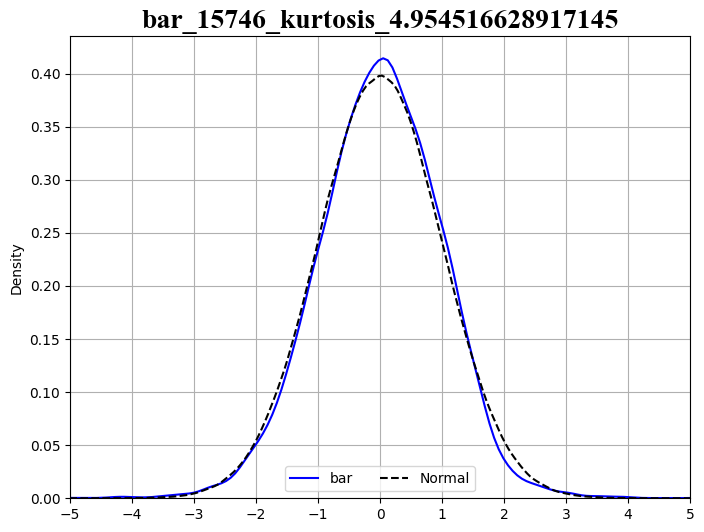

In [41]:
from custom_indicators.utils.plot import plot_kde

L = 5

plot_kde(merged_bar[:, 2], lag=L)

In [42]:
from hmmlearn.hmm import GMMHMM
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from jesse.helpers import timestamp_to_time

mix = 3  ### GMM mix参数

close_arr = merged_bar[:, 2]
high_arr = merged_bar[:, 3][L:]
low_arr = merged_bar[:, 4][L:]

log_return = np.log(close_arr[1:] / close_arr[:-1])[L - 1 :]
log_return_L = np.log(close_arr[L:] / close_arr[:-L])
HL_diff = np.log(high_arr / low_arr)

X = np.column_stack([HL_diff, log_return_L, log_return])

datelist = np.asarray(
    [pd.Timestamp(timestamp_to_time(i)) for i in merged_bar[:, 0][L:]]
)
closeidx = merged_bar[:, 2][L:]

assert len(datelist) == len(closeidx)
assert len(datelist) == len(X)

gmm = GMMHMM(
    n_components=2,
    n_mix=mix,
    covariance_type="diag",
    n_iter=1000,
    # weights_prior=2,
    means_weight=0.5,
    random_state=14,
)
gmm.fit(X)
latent_states_sequence = gmm.predict(X)

print(np.unique(latent_states_sequence, return_counts=True))

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for i in range(gmm.n_components):
    state = latent_states_sequence == i
    fig.add_trace(
        go.Scatter(
            x=datelist[state],
            y=closeidx[state],
            mode="markers",
            name=f"latent state {i}",
            marker=dict(color=colors[i % len(colors)], size=4),
        )
    )

fig.update_layout(
    title="隐含状态序列",
    xaxis_title="时间",
    yaxis_title="收盘价",
    # width=1400,
    # height=600,
    showlegend=True,
)

fig.show()

(array([0, 1]), array([7230, 8511]))


state 0 (7230) return: -3034.104923%
state 1 (8511) return: 3302.859621%


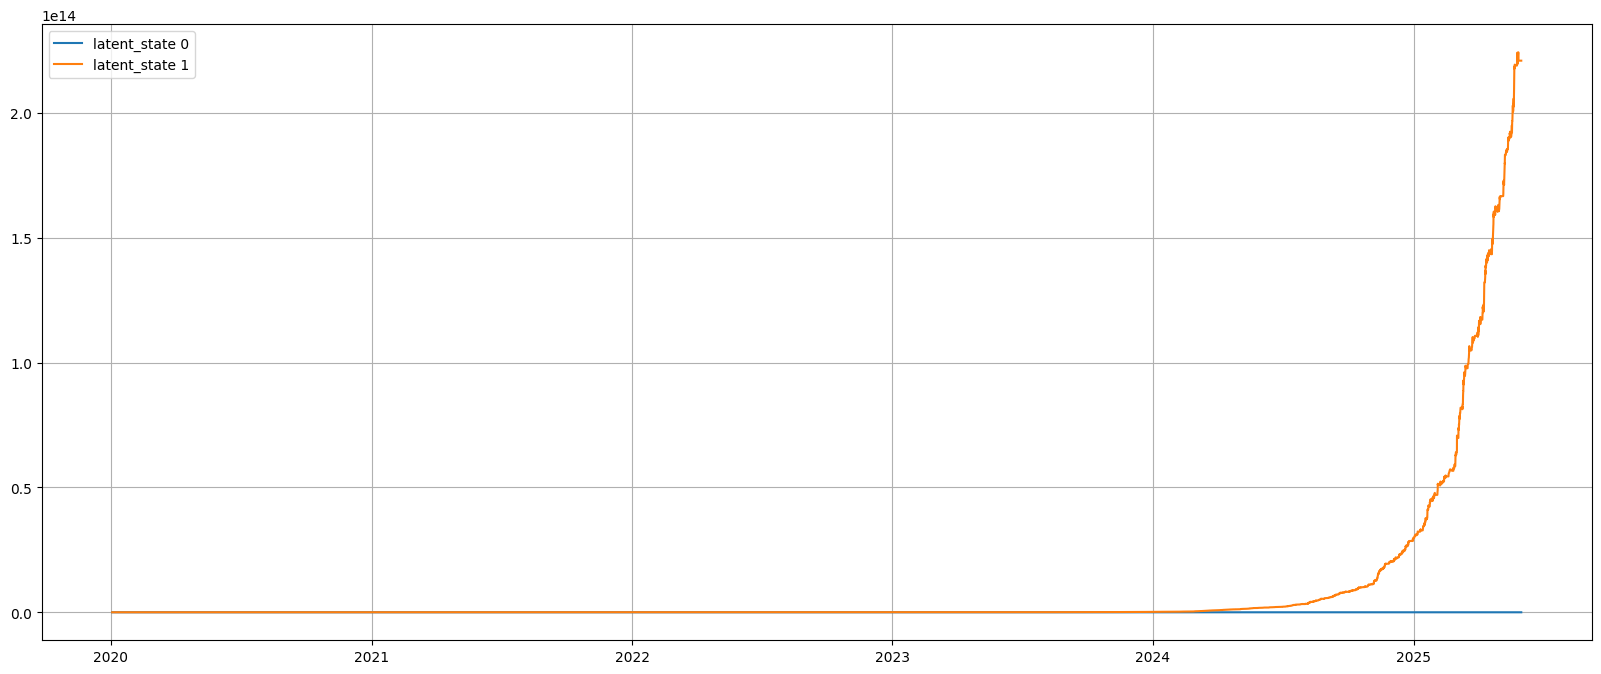

In [43]:
import matplotlib.pyplot as plt

data = pd.DataFrame(
    {
        "datelist": datelist,
        "logreturn": log_return,
        "state": latent_states_sequence,
    }
).set_index("datelist")

for i in data["state"].unique():
    ret = data[data["state"] == i]["logreturn"].sum()
    count = data[data["state"] == i].shape[0]
    print(f"state {i} ({count}) return: {ret:.6%}")

plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    idx = np.append(0, state[1:])
    data["state %d_return" % i] = data.logreturn.multiply(idx, axis=0)
    plt.plot(np.exp(data["state %d_return" % i].cumsum()), label="latent_state %d" % i)
    plt.legend(loc="upper left")
    plt.grid(1)

In [44]:
assert len(merged_bar[L:]) == len(latent_states_sequence)

In [45]:
# 保存merged bar, 去除最后一个bar，因为需要label前移一位
print(merged_bar[:-1].shape)
np.save("data/merged_bar.npy", merged_bar[:-1])

(15745, 6)


In [46]:
# 上涨下跌统一打标的情况

label = (latent_states_sequence == 1).astype(int)
print(np.unique(label, return_counts=True))
np.save("data/side_label.npy", label)

(array([0, 1]), array([7230, 8511]))


In [69]:
# 上涨下跌分别打标的情况

# label_long = (latent_states_sequence == 1).astype(int)
# print(np.unique(label_long, return_counts=True))
# np.save("data/side_label_long.npy", label_long)

# label_short = (latent_states_sequence == 0).astype(int)
# print(np.unique(label_short, return_counts=True))
# np.save("data/side_label_short.npy", label_short)


(array([0, 1]), array([5981, 2079]))
(array([0, 1]), array([6069, 1991]))


# Label meta

In [1]:
import numpy as np
import pandas as pd
from strategies.BinanceBtcEntropyBarV1.config import SIDE_LONG, SIDE_SHORT
from strategies.BinanceBtcEntropyBarV1.config import get_side_model

model_long = get_side_model(False, "long")
model_short = get_side_model(False, "short")

df_features = pd.read_parquet("data/features.parquet")

res_long = model_long.predict(df_features[SIDE_LONG])
res_short = model_short.predict(df_features[SIDE_SHORT])

label_long_pred = np.where(res_long > 0.5, 1, 0)
label_short_pred = np.where(res_short > 0.5, 1, 0)
print(label_long_pred.shape)
print(label_short_pred.shape)

print(np.unique(label_long_pred, return_counts=True))
print(np.unique(label_short_pred, return_counts=True))

/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/jesse/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


(7996,)
(7996,)
(array([0, 1]), array([5912, 2084]))
(array([0, 1]), array([5550, 2446]))


In [2]:
meta_long = np.full_like(label_long_pred, 0)  # 假设所有判断均不正确
raw_bar = np.load("data/merged_bar.npy")
log_ret = np.log(raw_bar[1:, 2] / raw_bar[:-1, 2])
len_gap = len(log_ret) - len(label_long_pred)
log_ret = log_ret[len_gap:]

cumsum_ret = 0
start_idx = 0
end_idx = 0
for idx, (i, r) in enumerate(zip(label_long_pred, log_ret)):
    if i == 1:
        if label_long_pred[idx - 1] == 0:
            # 开始做多
            start_idx = idx
        else:
            # 继续做多
            cumsum_ret += r
    else:
        if label_long_pred[idx - 1] == 1:
            # 结束做多，计算收益
            end_idx = idx
            cumsum_ret += r
            if cumsum_ret > 0:
                # 如果收益为正，则认为判断正确
                assert start_idx < end_idx, "start_idx must be less than end_idx"
                meta_long[start_idx:end_idx] = 1
            # 重置收益
            cumsum_ret = 0
            start_idx = 0
            end_idx = 0
        else:
            continue

np.unique(meta_long, return_counts=True)

(array([0, 1]), array([6000, 1996]))

In [3]:
meta_short = np.full_like(label_short_pred, 0)  # 假设所有判断均不正确
raw_bar = np.load("data/merged_bar.npy")
log_ret = np.log(raw_bar[1:, 2] / raw_bar[:-1, 2])
len_gap = len(log_ret) - len(label_short_pred)
log_ret = log_ret[len_gap:]

cumsum_ret = 0
start_idx = 0
end_idx = 0
for idx, (i, r) in enumerate(zip(label_short_pred, log_ret)):
    if i == 1:
        if label_short_pred[idx - 1] == 0:
            # 开始做空
            start_idx = idx
        else:
            # 继续做空
            cumsum_ret += r
    else:
        if label_short_pred[idx - 1] == 1:
            # 结束做空，计算收益
            end_idx = idx
            cumsum_ret += r
            if cumsum_ret < 0:
                # 如果收益为负，则认为判断正确
                assert start_idx < end_idx, "start_idx must be less than end_idx"
                meta_short[start_idx:end_idx] = 1
            # 重置收益
            cumsum_ret = 0
            start_idx = 0
            end_idx = 0
        else:
            continue

np.unique(meta_short, return_counts=True)

(array([0, 1]), array([6399, 1597]))

In [4]:
meta_long_final = ((meta_long == 1) & (meta_short == 0)).astype(int)
meta_short_final = ((meta_short == 1) & (meta_long == 0)).astype(int)

print(np.unique(meta_long_final, return_counts=True))
print(np.unique(meta_short_final, return_counts=True))

(array([0, 1]), array([6034, 1962]))
(array([0, 1]), array([6433, 1563]))


In [5]:
meta_final = ((meta_long_final == 1) | (meta_short_final == 1)).astype(int)

print(np.unique(meta_final, return_counts=True))

(array([0, 1]), array([4471, 3525]))


In [6]:
np.save("data/label_meta.npy", meta_final)